<div align="center">

# Customer Segmentation & Retention Analysis (RFM Model)
### Data Cleaning • Exploration • Segmentation • Insights

</div>

In [1]:
# Install required packages if not present (run once)
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scikit-learn sqlalchemy jupyterlab pyarrow openpyxl --quiet
print("Packages check/install done.")


Packages check/install done.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


# 01_Data_ingest_and_cleaning.ipynb
**Objective:** Load the raw Online Retail dataset, perform reproducible cleaning, create derived features (TotalPrice), document all decisions, and save an `interim` cleaned CSV for the next phase.

**Notebook structure**
1. Setup & imports  
2. Load raw dataset & quick glance
3. Standardize column names
4. Data type fixes & derived columns   
5. Data Cleaning – Fixing Invalid or Unrealistic Values
6. Duplicates & suspicious rows
7. Exploratory checks & visualizations (QC)  
8. Saving Cleaned Dataset
9. Notes to include in README & documentation
   
   

## 1. Setup & imports
Import libraries and set display options for readability.


In [4]:
# Imports and display settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

## 2. Load raw dataset & quick glance
Load the raw Excel. Show shape, column names, sample rows, and basic info.


In [6]:
# Load dataset
file_path = r"C:\Users\AZAN LAPTOP STORE\Downloads\Portfolio\Projects\Customer Segmentation & Retention Analysis (RFM Model)\data\online_retail.csv"
df = pd.read_csv(file_path, encoding='latin1')

# Quick check
print(df.shape)
display(df.head())
display(df.columns.tolist())

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


['InvoiceNo',
 'StockCode',
 'Description',
 'Quantity',
 'InvoiceDate',
 'UnitPrice',
 'CustomerID',
 'Country']

## 3. Standardize column names
Make sure column names are consistent and lowercased (but keep original names in a note).


In [7]:
# Normalize column names (strip, lower, no spaces)
df.columns = [c.strip() for c in df.columns]
# Optional: keep original mapping (useful to document)
col_map = {
    'InvoiceNo':'InvoiceNo', 'StockCode':'StockCode', 'Description':'Description',
    'Quantity':'Quantity', 'InvoiceDate':'InvoiceDate', 'UnitPrice':'UnitPrice',
    'CustomerID':'CustomerID', 'Country':'Country'
}
# show mapping and any unexpected columns
print("Columns after strip:", df.columns.tolist())
unexpected = [c for c in df.columns if c not in col_map]
print("Unexpected columns:", unexpected)


Columns after strip: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
Unexpected columns: []


## 4. Data types & create derived columns
Convert InvoiceDate to datetime, ensure numeric types for Quantity & UnitPrice, and create TotalPrice.


In [9]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Force numeric types
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], errors='coerce')

# Create TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Quick checks
display(df[['InvoiceDate','Quantity','UnitPrice','TotalPrice']].describe(include='all').T)
display(df[['InvoiceDate','Quantity','UnitPrice','TotalPrice']].head())


,count,mean,min,25%,50%,75%,max,std
InvoiceDate,541909,2011-07-04 13:34:57.156386048,2010-12-01 08:26:00,2011-03-28 11:34:00,2011-07-19 17:17:00,2011-10-19 11:27:00,2011-12-09 12:50:00,NaN
Quantity,541909.0,9.55225,-80995.0,1.0,3.0,10.0,80995.0,218.081158
UnitPrice,541909.0,4.611114,-11062.06,1.25,2.08,4.13,38970.0,96.759853
TotalPrice,541909.0,17.987795,-168469.6,3.4,9.75,17.4,168469.6,378.810824


,InvoiceDate,Quantity,UnitPrice,TotalPrice
0,2010-12-01 08:26:00,6,2.55,15.30
1,2010-12-01 08:26:00,6,3.39,20.34
2,2010-12-01 08:26:00,8,2.75,22.00
3,2010-12-01 08:26:00,6,3.39,20.34
4,2010-12-01 08:26:00,6,3.39,20.34


## 5. Data Cleaning – Fixing Invalid or Unrealistic Values

Before any analysis, we must ensure our dataset is **clean and reliable**.  
E-commerce data often includes errors like:
- Negative or zero quantities (returns, input mistakes)
- Unrealistically high prices or quantities (data entry errors)
- Missing Customer IDs  

We'll fix these step by step to prepare a high-quality dataset.


In [10]:
# Remove negative or zero quantities and prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Drop missing Customer IDs (often needed for RFM)
df = df.dropna(subset=['CustomerID'])

# Recalculate total after cleaning
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Check summary again
print(df[['Quantity','UnitPrice','TotalPrice']].describe())


            Quantity      UnitPrice     TotalPrice
count  397884.000000  397884.000000  397884.000000
mean       12.988238       3.116488      22.397000
std       179.331775      22.097877     309.071041
min         1.000000       0.001000       0.001000
25%         2.000000       1.250000       4.680000
50%         6.000000       1.950000      11.800000
75%        12.000000       3.750000      19.800000
max     80995.000000    8142.750000  168469.600000


### 📊 Step 2: Detect and Remove Extreme Outliers

Even after removing invalid rows, we may still have **outliers** —  
values that are too high or too low compared to most of the data.  

We'll use the **Interquartile Range (IQR)** method, a robust statistical technique that detects and removes such extreme values.


In [11]:
# Function to remove outliers using IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply to Quantity and UnitPrice
df = remove_outliers_iqr(df, 'Quantity')
df = remove_outliers_iqr(df, 'UnitPrice')

# Recalculate TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Check again after removing outliers
df[['Quantity', 'UnitPrice', 'TotalPrice']].describe()


,Quantity,UnitPrice,TotalPrice
count,338151.000000,338151.000000,338151.000000
mean,7.476917,2.192017,12.771994
std,6.770795,1.544770,13.177003
min,1.000000,0.001000,0.001000
25%,2.000000,1.250000,3.800000
50%,6.000000,1.650000,10.080000
75%,12.000000,2.950000,17.400000
max,27.000000,7.500000,178.800000


## 6. Duplicates & suspicious rows
Check for exact duplicates and near duplicates and decide how to handle them.


In [19]:
# Check for exact duplicates
dup_exact = df.duplicated().sum()
print("Exact duplicate rows:", dup_exact)

# Drop if any
if dup_exact > 0:
    df = df.drop_duplicates()
    print("Dropped duplicates. New shape:", df.shape)

# Check partial duplicates (key columns)
dup_partial = df.duplicated(subset=['InvoiceNo','StockCode','Quantity','UnitPrice','InvoiceDate']).sum()
print("Duplicates by key columns:", dup_partial)

# Unique count summary
print("Unique customers:", df['CustomerID'].nunique())
print("Unique invoices:", df['InvoiceNo'].nunique())


Exact duplicate rows: 0
Duplicates by key columns: 1
Unique customers: 4191
Unique invoices: 16826


## 7. Exploratory checks & visualizations (QC)
Run basic EDA to understand distributions: time distribution, top products, revenue distribution, and outliers.


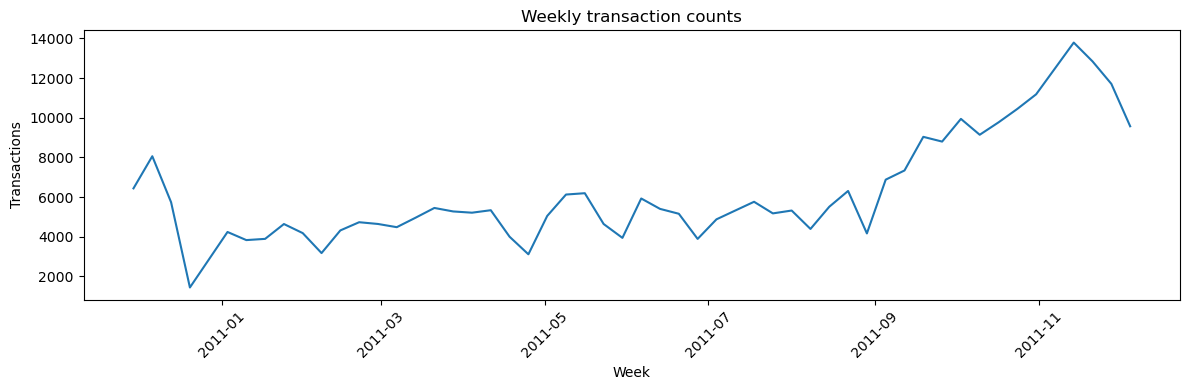

Total Revenue: 4299476.183999999


count    333234.000000
mean         12.902273
std          13.214967
min           0.001000
25%           3.900000
50%          10.140000
75%          17.400000
max         178.800000
Name: TotalPrice, dtype: float64

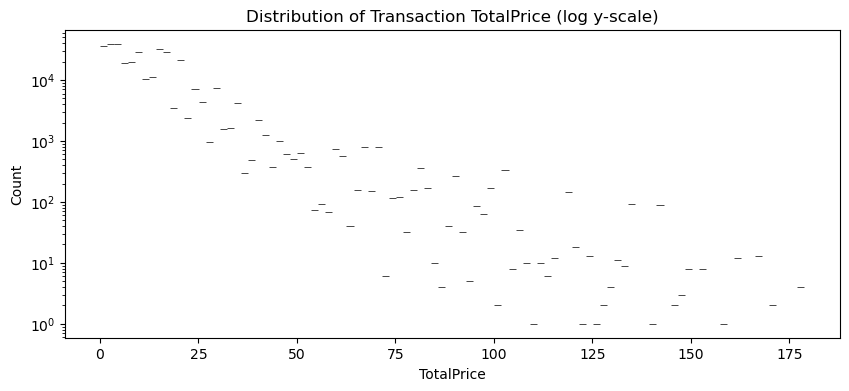

Description
PARTY BUNTING                         34952.85
WHITE HANGING HEART T-LIGHT HOLDER    31763.76
JUMBO BAG RED RETROSPOT               24923.50
SPOTTY BUNTING                        23513.05
ASSORTED COLOUR BIRD ORNAMENT         22940.06
JAM MAKING SET WITH JARS              21137.25
HOT WATER BOTTLE KEEP CALM            20617.35
SET OF 3 CAKE TINS PANTRY DESIGN      20583.97
CHOCOLATE HOT WATER BOTTLE            18422.85
CHILLI LIGHTS                         18379.80
Name: TotalPrice, dtype: float64

CustomerID
14911.0    84980.89
13089.0    36347.88
14096.0    36019.84
17841.0    32224.59
14298.0    24387.53
12748.0    20519.88
14156.0    18276.11
13081.0    17925.53
15311.0    17712.96
14088.0    15700.62
Name: TotalPrice, dtype: float64

In [15]:
# Use df instead of df_clean
df['InvoiceWeek'] = df['InvoiceDate'].dt.to_period('W').apply(lambda r: r.start_time)

# Transactions per week
weekly_counts = df.groupby('InvoiceWeek').size().rename('transactions').reset_index()
plt.figure(figsize=(12,4))
plt.plot(weekly_counts['InvoiceWeek'], weekly_counts['transactions'])
plt.title("Weekly transaction counts")
plt.xlabel("Week")
plt.ylabel("Transactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Revenue summary
print("Total Revenue:", df['TotalPrice'].sum())
display(df['TotalPrice'].describe())

plt.figure(figsize=(10,4))
sns.histplot(df['TotalPrice'].clip(lower=0), bins=100, log_scale=(False, True))
plt.title("Distribution of Transaction TotalPrice (log y-scale)")
plt.show()

# Top 10 products by revenue
top_products = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)
display(top_products)

# Top 10 customers by revenue
top_customers = df.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False).head(10)
display(top_customers)



## 8. Saving Cleaned Dataset
Now that the data has been cleaned, let's summarize what remains and save it for further RFM (Recency, Frequency, Monetary) analysis.


In [20]:
# Get total rows after cleaning
final_rows = df.shape[0]

# Basic data summary
print("Final total rows:", final_rows)
print("Unique customers:", df['CustomerID'].nunique())
print("Date range:", df['InvoiceDate'].min(), "to", df['InvoiceDate'].max())

save_path = r"C:\Users\AZAN LAPTOP STORE\Downloads\Portfolio\Projects\Customer Segmentation & Retention Analysis (RFM Model)\data"

df.to_csv(os.path.join(save_path, "online_retail_cleaned.csv"), index=False)
df.sample(100, random_state=42).to_csv(os.path.join(save_path, "online_retail_sample100.csv"), index=False)

print("Files saved in:", save_path)


Final total rows: 333234
Unique customers: 4191
Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Files saved in: C:\Users\AZAN LAPTOP STORE\Downloads\Portfolio\Projects\Customer Segmentation & Retention Analysis (RFM Model)\data


## 9. Notes to include in README & documentation
- Source: Kaggle Online Retail dataset (record source URL + download date)
- Key cleaning decisions:
  - Dropped rows with missing `CustomerID` because RFM requires unique customers.
  - Removed returns (Quantity <= 0) and cancelled invoices (InvoiceNo starting with 'C') from main RFM dataset. A separate returns file is saved for later analysis.
  - Converted `InvoiceDate` to datetime and created `TotalPrice = Quantity * UnitPrice`.
  - Removed exact duplicates after inspection.
